In [34]:
!pip uninstall -y numpy
!pip install numpy==1.26

Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6


You can safely remove it manually.
You can safely remove it manually.


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.0-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.0-cp312-cp312-win_amd64.whl (15.5 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cornac 2.3.3 requires numpy>2.0.0, but you have numpy 1.26.0 which is incompatible.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from collections import defaultdict
import math
from tqdm import tqdm
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [3]:
# Load CSVs
recipes = pd.read_csv("recipes.csv")
reviews = pd.read_csv("reviews.csv")

print(recipes.shape, reviews.shape)
recipes.head()


(522517, 28) (1401982, 8)


,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [4]:
print(recipes.shape, reviews.shape)
reviews.head()

(522517, 28) (1401982, 8)


,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [5]:
# Drop duplicate recipes/reviews
recipes = recipes.drop_duplicates(subset="RecipeId")
reviews = reviews.drop_duplicates(subset="ReviewId")

nutritional_cols = [
    "Calories","FatContent","SaturatedFatContent","CholesterolContent",
    "SodiumContent","CarbohydrateContent","FiberContent","SugarContent","ProteinContent"
]
for col in nutritional_cols:
    recipes[col] = pd.to_numeric(recipes[col], errors="coerce")


In [6]:
n_users = reviews["AuthorId"].nunique()
n_items = reviews["RecipeId"].nunique()

# Total ratings
n_ratings = len(reviews)

# Average ratings
avg_ratings_per_user = n_ratings / n_users
avg_ratings_per_item = n_ratings / n_items
avg_rating = reviews["Rating"].mean()
rating_sd = reviews["Rating"].std()

ratings_per_user = reviews.groupby("AuthorId").size()
ratings_per_item = reviews.groupby("RecipeId").size()

max_ratings_by_user = ratings_per_user.max()
max_ratings_by_item = ratings_per_item.max()

# Density of ratings
density = n_ratings / (n_users * n_items)

print(density)

# Put it all into a summary table
summary = pd.DataFrame({
    "Number of users": [n_users],
    "Number of items": [n_items],
    "Total ratings": [n_ratings],
    "Avg ratings per user": [avg_ratings_per_user],
    "Avg ratings per item": [avg_ratings_per_item],
    "Avg rating": [avg_rating],
    "Rating SD": [rating_sd],
    "Max ratings by user": [max_ratings_by_user],
    "Max ratings by item": [max_ratings_by_item],
    "Density": [density]
})

display(summary.round(3))

1.897874882176401e-05


,Number of users,Number of items,Total ratings,Avg ratings per user,Avg ratings per item,Avg rating,Rating SD,Max ratings by user,Max ratings by item,Density
0,271907,271678,1401982,5.156,5.16,4.408,1.272,8842,2892,0.0


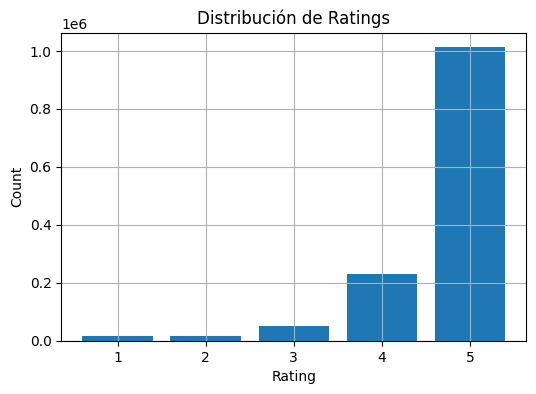

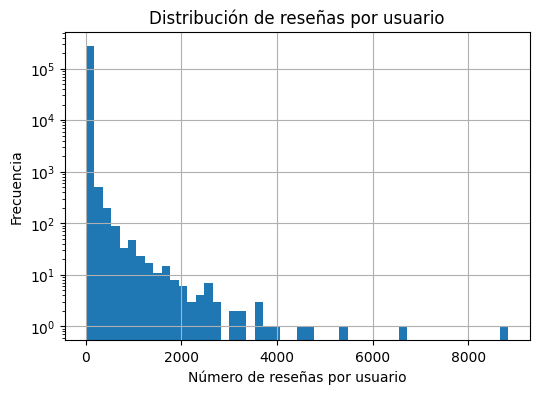

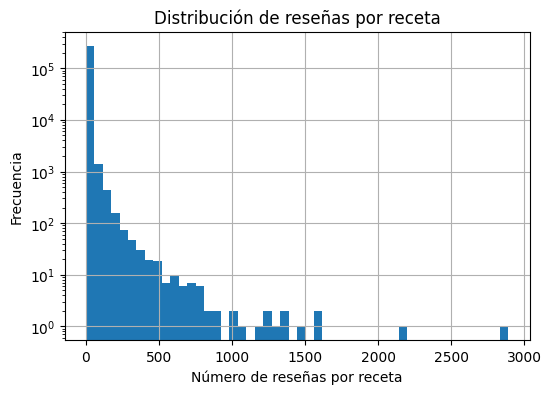

RMSE Random: 2.366919248598748
RMSE Item mean: 1.342615210648378
RMSE User mean: 1.265473154812713


In [7]:
# Rating distribution
plt.figure(figsize=(6,4))
reviews["Rating"].hist(bins=np.arange(0.5, 6, 1), rwidth=0.8)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribución de Ratings")
plt.show()

# Numero de reseñas por usuario
user_counts = reviews.groupby("AuthorId").size()
plt.figure(figsize=(6,4))
user_counts.hist(bins=50, log=True)
plt.xlabel("Número de reseñas por usuario")
plt.ylabel("Frecuencia")
plt.title("Distribución de reseñas por usuario")
plt.show()

item_counts = reviews.groupby("RecipeId").size()
plt.figure(figsize=(6,4))
item_counts.hist(bins=50, log=True)
plt.xlabel("Número de reseñas por receta")
plt.ylabel("Frecuencia")
plt.title("Distribución de reseñas por receta")
plt.show()

# Split train/test
train, test = train_test_split(reviews, test_size=0.2)

# Random predictions
test["pred_random"] = np.random.randint(1, 6, size=len(test))

# Most Popular (item mean)
item_means = train.groupby("RecipeId")["Rating"].mean()
test["pred_item_mean"] = test["RecipeId"].map(item_means).fillna(train["Rating"].mean())

# User Mean
user_means = train.groupby("AuthorId")["Rating"].mean()
test["pred_user_mean"] = test["AuthorId"].map(user_means).fillna(train["Rating"].mean())

rmse_random = root_mean_squared_error(test["Rating"], test["pred_random"])
rmse_item = root_mean_squared_error(test["Rating"], test["pred_item_mean"])
rmse_user = root_mean_squared_error(test["Rating"], test["pred_user_mean"])

print("RMSE Random:", rmse_random)
print("RMSE Item mean:", rmse_item)
print("RMSE User mean:", rmse_user)


In [8]:
def get_top_n(predictions, n=10): # Obtenida de https://surprise.readthedocs.io/en/stable/FAQ.html
    """Devuelve el top-N para cada usuario a partir de un conjunto de predicciones."""

    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Ordenar predicciones por score
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
popular_items = (
    train.groupby("RecipeId")["Rating"]
    .count()
    .sort_values(ascending=False)
    .index
    .tolist()
)

# Items seen by each user
user_items_train = train.groupby("AuthorId")["RecipeId"].apply(set).to_dict()
all_items = set(train["RecipeId"].unique())

user_means = train.groupby("AuthorId")["Rating"].mean().to_dict()
item_means = train.groupby("RecipeId")["Rating"].mean().to_dict()
global_mean = train["Rating"].mean()


In [10]:
all_items = np.array(list(train["RecipeId"].unique()))
shuffled_items = np.random.permutation(all_items)

def recommend_random(uid, n=10):
    seen = user_items_train.get(uid, set())
    recs = [iid for iid in shuffled_items if iid not in seen]
    return recs[:n]


def recommend_popular(uid, n=10):
    seen = user_items_train.get(uid, set())
    recs = [iid for iid in popular_items if iid not in seen]
    return recs[:n]

In [11]:
def precision_recall_at_k(recs, relevant, k=10):
    recs_k = recs[:k]
    hits = len(set(recs_k) & set(relevant))
    precision = hits / k if k else 0
    recall = hits / len(relevant) if relevant else 0
    return precision, recall

def ndcg_at_k(recs, relevant, k=10):
    recs_k = recs[:k]
    dcg = sum(1 / math.log2(i+2) for i, iid in enumerate(recs_k) if iid in relevant)
    idcg = sum(1 / math.log2(i+2) for i in range(min(len(relevant), k)))
    return dcg / idcg if idcg > 0 else 0


In [18]:
# Build test relevance dict (what items each user interacted with in test set)
user_items_test = test.groupby("AuthorId")["RecipeId"].apply(set).to_dict()

In [ ]:
results = {"random": [], "popular": []}
k = 10

# Evaluate
for uid, relevant in tqdm(user_items_test.items(), desc="Evaluating users"):
    # Random
    recs_rand = recommend_random(uid, n=k)
    p, r = precision_recall_at_k(recs_rand, relevant, k)
    n = ndcg_at_k(recs_rand, relevant, k)
    results["random"].append((p, r, n))
    
    # Popular
    recs_pop = recommend_popular(uid, n=k)
    p, r = precision_recall_at_k(recs_pop, relevant, k)
    n = ndcg_at_k(recs_pop, relevant, k)
    results["popular"].append((p, r, n))


Evaluating users: 100%|██████████| 83204/83204 [29:22<00:00, 47.20it/s]


In [ ]:
def summarize(name, scores):
    scores = np.array(scores)
    print(f"{name} -- Precision@{k}: {scores[:,0].mean():.4f}, "
          f"Recall@{k}: {scores[:,1].mean():.4f}, "
          f"NDCG@{k}: {scores[:,2].mean():.4f}")

summarize("Random", results["random"])
summarize("Most Popular", results["popular"])


Random -- Precision@10: 0.0000, Recall@10: 0.0000, NDCG@10: 0.0000
Most Popular -- Precision@10: 0.0040, Recall@10: 0.0212, NDCG@10: 0.0129


In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(reviews[["AuthorId", "RecipeId", "Rating"]], reader)

trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD()
algo.fit(trainset)

# Predict on test set
predictions = algo.test(testset)
rmse_svd = accuracy.rmse(predictions, verbose=True)
mae_svd = accuracy.mae(predictions, verbose=True)
print("RMSE SVD:", rmse_svd)

# Get recommendations
top_n = get_top_n(predictions, n=10)

# Example: print recommendations for first 3 users
for uid, recs in list(top_n.items())[:3]:
    print(f"Usuario {uid} -> {[iid for iid, _ in recs]}")


RMSE: 1.2289
MAE:  0.7465
RMSE SVD: 1.228867605369821
MAE SVD: 0.7465289563303411


In [34]:
def get_top_n(predictions, n=10):
    """Devuelve las N-mejores recomendaciones para cada usuario de un set de predicción.

    Args:
        predictions(lista de objetos Prediction): La lista de predicción obtenida del método test.
        n(int): El número de recomendaciónes por usuario

    Returns:
    Un diccionario donde las llaves son ids de usuario y los valores son listas de tuplas:
        [(item id, rating estimation), ...] de tamaño n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Example: print recommendations for first 3 users
for uid, recs in list(top_n.items())[:3]:
    print(f"Usuario {uid} -> {[iid for iid, _ in recs]}")

Usuario 839492 -> [9272, 50847, 23821, 92072, 39052, 55309, 9265, 74608, 35544, 101003]
Usuario 335606 -> [89204, 337423, 104975, 33113, 3221, 26516, 41843, 26441, 30864, 50772]
Usuario 594139 -> [147982, 255531, 422042, 94133, 307637, 41142, 184668, 41694, 334331, 263713]


In [ ]:
test_user_items = defaultdict(list)
for uid, iid in zip(test["AuthorId"], test["RecipeId"]):
    test_user_items[uid].append(iid)


In [ ]:
def precision_recall_at_k(top_n, test_user_items, k=10):
    precisions = []
    recalls = []
    for uid, recs in top_n.items():
        if uid not in test_user_items:
            continue
        relevant = set(test_user_items[uid])
        recommended = set([iid for iid, _ in recs[:k]])
        precisions.append(len(recommended & relevant) / k)
        recalls.append(len(recommended & relevant) / len(relevant))
    return np.mean(precisions), np.mean(recalls)

precision, recall = precision_recall_at_k(top_n, test_user_items, k=10)
print(f"Precision@10: {precision:.4f}, Recall@10: {recall:.4f}")

def ndcg_at_k(top_n, test_user_items, k=10):
    ndcgs = []
    for uid, recs in top_n.items():
        if uid not in test_user_items:
            continue
        relevant = set(test_user_items[uid])
        dcg = 0
        for i, (iid, _) in enumerate(recs[:k]):
            if iid in relevant:
                dcg += 1 / math.log2(i + 2) 
        idcg = sum(1 / math.log2(i + 2) for i in range(min(k, len(relevant))))
        ndcgs.append(dcg / idcg if idcg > 0 else 0)
    return np.mean(ndcgs)

ndcg = ndcg_at_k(top_n, test_user_items, k=10)
print(f"NDCG@10: {ndcg:.4f}")


Precision@10: 0.0841, Recall@10: 0.4294
NDCG@10: 0.4319
